### Visualize the PHOCNet results with BCE logit loss

In [5]:
import argparse
import logging

import numpy as np
import torch.autograd
import torch.cuda
import torch.nn as nn
import torch.optim
from torch.utils.data import DataLoader
import tqdm

import copy
from datasets.maps_alt import MAPSDataset

#from cnn_ws.transformations.homography_augmentation import HomographyAugmentation
from cnn_ws.losses.cosine_loss import CosineLoss

from cnn_ws.models.myphocnet import PHOCNet
from cnn_ws.evaluation.retrieval import map_from_feature_matrix, map_from_query_test_feature_matrices
from torch.utils.data.dataloader import _DataLoaderIter as DataLoaderIter
from torch.utils.data.sampler import WeightedRandomSampler

from cnn_ws.utils.save_load import my_torch_save, my_torch_load

#import matplotlib.pyplot as plt

In [6]:
def learning_rate_step_parser(lrs_string):
    return [(int(elem.split(':')[0]), float(elem.split(':')[1])) for elem in lrs_string.split(',')]

In [7]:
# parameters
embedding_type = 'phoc'
phoc_unigram_levels = [1,2,4,8]
fixed_image_size = None
min_image_width_height = 26

In [8]:
f = open('../splits/val_files.txt', 'rb')
all_files = f.readlines()
all_files = [x.strip('\n') for x in all_files]
f.close()

test_set = MAPSDataset(map_root_dir1='../../../ProcessedData/',
                map_root_dir2='../../../ProcessedData/',
                all_files=all_files,
                embedding=embedding_type,
                phoc_unigram_levels=phoc_unigram_levels,
                fixed_image_size=fixed_image_size,
                min_image_width_height=min_image_width_height)

100%|██████████| 8451/8451 [00:00<00:00, 10371.86it/s]


In [9]:
if not torch.cuda.is_available():
    logger.warning('Could not find CUDA environment, using CPU mode')
    gpu_id = None
else:
    gpu_id = [0]
#torch.cuda.get_device_name(gpu_id[0])
pass

In [10]:
test_set.mainLoader(partition='test', transforms=None)

In [11]:
test_loader = DataLoader(test_set,
    batch_size=1,
    shuffle=False,
    num_workers=8)

In [12]:
# save the model in new format so its easy to read
#model_ = torch.load('PHOCNet.pt')
#model_parameters = {name : param.data for name, param in model_.named_parameters()}
#torch.save(model_parameters, 'PHOCNet_new.pt')

In [13]:
cnn = PHOCNet(n_out=list(test_set[0][1].size())[0],
    input_channels=3,
    gpp_type='gpp',
    pooling_levels=([1], [5]))

cnn.init_weights()

#print list(cnn.named_parameters())
pass

cnn_ws/models/myphocnet.py:88: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  nn.init.constant(m.bias.data, 0)


In [14]:
'''
my_torch_load(cnn, 'PHOCNet_new.pt')

if gpu_id is not None:
        if len(gpu_id) > 1:
            cnn = nn.DataParallel(cnn, device_ids=gpu_id)
            cnn.cuda()
        else:
            cnn.cuda(gpu_id[0])
'''
pass
#print list(cnn.named_parameters())

In [15]:
model_ = torch.load('PHOCNet_all_case.pt')
cnn = model_.module#list(model_.named_parameters())
if gpu_id is not None:
        if len(gpu_id) > 1:
            cnn = nn.DataParallel(cnn, device_ids=gpu_id)
            cnn.cuda()
        else:
            cnn.cuda(gpu_id[0])

In [16]:
def evaluate_cnn(cnn, dataset_loader, gpu_id):
    logger = logging.getLogger('PHOCNet-Experiment::test')
    # set the CNN in eval mode
    cnn.eval()
    logger.info('Computing net output:')
    qry_ids = [] #np.zeros(len(dataset_loader), dtype=np.int32)
    class_ids = np.zeros(len(dataset_loader), dtype=np.int32)
    embedding_size = dataset_loader.dataset.embedding_size()
    embeddings = np.zeros((len(dataset_loader), embedding_size), dtype=np.float32)
    outputs = np.zeros((len(dataset_loader), embedding_size), dtype=np.float32)
    eq = []
    for sample_idx, (word_img, embedding, class_id, is_query) in enumerate(tqdm.tqdm(dataset_loader)):
        #print(word_img.shape)
        if len(word_img.shape) > 4:
            #word_img = np.squeeze(word_img, axis=0)
            word_img = word_img[0]
        #print(word_img.shape)
        if gpu_id is not None:
            # in one gpu!!
            word_img = word_img.cuda(gpu_id[0])
            embedding = embedding.cuda(gpu_id[0])
            #word_img, embedding = word_img.cuda(args.gpu_id), embedding.cuda(args.gpu_id)
        
        word_img = torch.autograd.Variable(word_img)
        embedding = torch.autograd.Variable(embedding)
        ''' BCEloss ??? '''
        output = torch.sigmoid(cnn(word_img))
        #output = cnn(word_img)
        outputs[sample_idx] = output.data.cpu().numpy().flatten()
        embeddings[sample_idx] = embedding.data.cpu().numpy().flatten()
        class_ids[sample_idx] = class_id.numpy()[0,0]
        #eq = []
        if is_query[0] == 1:
            qry_ids.append(sample_idx)  #[sample_idx] = is_query[0]
            eq.append(embeddings[sample_idx])

    '''
    # find queries

    unique_class_ids, counts = np.unique(class_ids, return_counts=True)
    qry_class_ids = unique_class_ids[np.where(counts > 1)[0]]

    # remove stopwords if needed
    
    qry_ids = [i for i in range(len(class_ids)) if class_ids[i] in qry_class_ids]
    '''

    qry_outputs = outputs[qry_ids][:]
    qry_class_ids = class_ids[qry_ids]

    # run word spotting
    logger.info('Computing mAPs...')

    ave_precs_qbe = map_from_query_test_feature_matrices(query_features = qry_outputs,
                                                         test_features=outputs,
                                                         query_labels = qry_class_ids,
                                                         test_labels=class_ids,
                                                         metric='cosine',
                                                         drop_first=True)

    logger.info('mAP: %3.2f', np.mean(ave_precs_qbe[ave_precs_qbe > 0])*100)
    print 'mAP: ', np.mean(ave_precs_qbe[ave_precs_qbe > 0])*100
    return outputs, qry_ids, class_ids, eq

In [17]:
# evaluation (checking if I was correct or not)
outputs, qry_ids, class_ids, eq = evaluate_cnn(cnn=cnn,
        dataset_loader=test_loader,
        gpu_id=gpu_id)

  0%|          | 0/2536 [00:00<?, ?it/s]Exception NameError: "global name 'FileNotFoundError' is not defined" in <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x2aab2205e350>> ignored
Exception KeyError: KeyError(<weakref at 0x2aab22059cb0; to 'tqdm' at 0x2aaab46edb90>,) in <bound method tqdm.__del__ of   0%|          | 0/2536 [00:02<?, ?it/s]> ignored


ValueError: could not broadcast input array from shape (945) into shape (540)

In [18]:
#print outputs.shape, len(qry_ids), class_ids.shape, len(eq)
from scipy.spatial.distance import cdist, pdist, squareform
def find_matches(outputs, eq, metric, k):
    # find sthe best distance between the embeddings and the output of cnn and returns matches
    dist_mat = cdist(XA=outputs, XB=eq, metric=metric)
    retrieval_indices = np.argsort(dist_mat, axis=1)
    #print retrieval_indices
    q = retrieval_indices[:,:k]
    #print q
    p = np.arange(len(q))
    print (np.sum(p==q)), float(len(q))
    return float(np.sum(p==q))/float(len(q))

In [19]:
matches_percent = find_matches(outputs=outputs[qry_ids], eq=np.asarray(eq), metric = 'euclidean', k=1)
print 'the accuracy for k=1 is: '+str(matches_percent)

NameError: name 'outputs' is not defined

In [20]:
# find the file names
f = open('../splits/val_files.txt', 'rb')
A = f.readlines()
f.close()
A = [x.rstrip('\n') for x in A]

In [21]:
# load test images and words
images = np.load('../../../ProcessedData/original_images_nopad_'+A[0]+'.tiff.npy')
words = np.load('../../../ProcessedData/original_words_nopad_'+A[0]+'.tiff.npy')

In [22]:
# # increasing the length of the word list (do this only if necessary)
# words = list(words)
# for i in words:
#     words.append(i[1:])
#     words.append(i[:-1])
# words = np.array(words)

In [23]:
# convert dimensions
images = np.transpose(images, (0,3,1,2))
images.shape

(544, 3, 135, 487)

In [24]:
# check if this works
outputs = []
for i in range(len(images)):
    word_img = images[i]
    word_img = 1 - word_img.astype(np.float32) / 255.0
    word_img = word_img.reshape((1,) + word_img.shape)
    word_img = torch.from_numpy(word_img).float()
    word_img = word_img.cuda(gpu_id[0])
    word_img = torch.autograd.Variable(word_img)
    output = torch.sigmoid(cnn(word_img))
    output = output.data.cpu().numpy().flatten()
    outputs.append(output)

In [41]:
def create_word_variations(words):
    word_var = {}
    root_word_var = {}
    for w in words:
        if len(w) < 2:
            continue
        root_var_list = [w.lower(), w.upper(), w.capitalize()]
        var_set = set()
        for var in root_var_list:
            word_var[var] = 0
            word_var[var[1:]] = 1
            word_var[var[:-1]] = -1
            var_set.add(var)
            var_set.add(var[1:])
            var_set.add(var[:-1])
        root_word_var[w] = var_set
    return word_var, root_word_var

In [42]:
print(create_word_variations(['Mudit', 'babadook']))

({'BABADOO': -1, 'ABADOOK': 1, 'mudi': -1, 'BABADOOK': 0, 'mudit': 0, 'Babadoo': -1, 'MUDIT': 0, 'Mudit': 0, 'babadoo': -1, 'abadook': 1, 'UDIT': 1, 'Mudi': -1, 'udit': 1, 'Babadook': 0, 'MUDI': -1, 'babadook': 0}, {'Mudit': set(['mudi', 'mudit', 'MUDIT', 'Mudit', 'UDIT', 'Mudi', 'udit', 'MUDI']), 'babadook': set(['ABADOOK', 'babadoo', 'Babadoo', 'BABADOO', 'BABADOOK', 'abadook', 'Babadook', 'babadook'])})


In [63]:
# compute the PHOC representation of the word itself
from cnn_ws.string_embeddings.phoc import build_phoc_descriptor
word_strings = words
#unigrams = [chr(i) for i in range(ord('a'), ord('z') + 1) + range(ord('0'), ord('9') + 1)]
unigrams = [chr(i) for i in range(ord('&'), ord('&')+1) + range(ord('A'), ord('Z')+1) + \
                    range(ord('a'), ord('z') + 1) + range(ord('0'), ord('9') + 1)]
bigram_levels = None
bigrams = None
phoc_unigram_levels=(1, 2, 4, 8)

# for i in range(len(word_strings)):
#     word_strings[i] = word_strings[i].lower()

word_var_dir, root_word_var = create_word_variations(word_strings)
print(len(word_var_dir))

embedding = build_phoc_descriptor(words=word_strings,
                                  phoc_unigrams=unigrams,
                                  bigram_levels=bigram_levels,
                                  phoc_bigrams=bigrams,
                                  unigram_levels=phoc_unigram_levels)

word_var_strings = word_var_dir.keys()
embedding_var = build_phoc_descriptor(words=word_var_strings,
                                  phoc_unigrams=unigrams,
                                  bigram_levels=bigram_levels,
                                  phoc_bigrams=bigrams,
                                  unigram_levels=phoc_unigram_levels)

print embedding_var.shape

  0%|          | 0/2527 [00:00<?, ?it/s]

2527


100%|██████████| 2527/2527 [00:00<00:00, 4796.31it/s]

(2527, 945)


In [54]:
print(np.array(outputs).shape)
print(embedding_var.shape)

(544, 945)
(2527, 945)


In [59]:
from scipy.spatial.distance import cdist, pdist, squareform

def report_matches_with_variations(outputs, embedding_var, matching, word_strings, 
                                   word_var_strings, k, length):
    # length sorting stuff
    qualified_ids = [x for x in range(len(word_strings)) if len(word_strings[x]) > length]
    outputs = np.array(outputs)
    word_strings = np.array(word_strings)
    outputs = list(outputs[qualified_ids])
    word_strings = list(word_strings[qualified_ids])
    
    # same stuff for variations
    qualified_ids_vars = [x for x in range(len(word_var_strings)) if len(word_var_strings[x]) > (length-1)]
    embedding_var = np.array(embedding_var)
    word_var_strings = np.array(word_var_strings)
    embedding_var = list(embedding_var[qualified_ids_vars])
    word_var_strings = list(word_var_strings[qualified_ids_vars])
    
    # the real computation
    dist_mat = cdist(XA=outputs, XB=embedding_var, metric=matching)
    retrieval_indices = np.argsort(dist_mat, axis=1)
    q = retrieval_indices[:,:k]
    count = 0
    matched_words = []
    img_dir = []
    # get all matched words
    for i in range(len(q)):
        matched = []
        #print q[i]
        for j in q[i]:
            matched.append(word_var_strings[j])
            img_dir.append(word_var_dir[word_var_strings[j]])
        matched_words.append(matched)
    
    # calculate accuracies
    for i in range(len(word_strings)):
        #print word_strings[i]
        if word_strings[i] in matched_words[i]:
            count = count+1
        else:
            for w in matched_words[i]:
                if w in root_word_var[word_strings[i]]:
                    count = count+1
                    break

    #q = np.squeeze(np.array(q))
    #p = np.arange(len(q))
    #print count
    return count, matched_words, outputs, qualified_ids, img_dir, word_strings

In [60]:
from scipy.spatial.distance import cdist, pdist, squareform

def report_matches(outputs, embedding, matching, word_strings, k, length):
    # length sorting stuff
    qualified_ids = [x for x in range(len(word_strings)) if len(word_strings[x]) > length]
    outputs = np.array(outputs)
    embedding = np.array(embedding)
    word_strings = np.array(word_strings)
    outputs = list(outputs[qualified_ids])
    embedding = list(embedding[qualified_ids])
    word_strings = list(word_strings[qualified_ids])
    # the real computation
    dist_mat = cdist(XA=outputs, XB=embedding, metric=matching)
    retrieval_indices = np.argsort(dist_mat, axis=1)
    q = retrieval_indices[:,:k]
    count = 0
    matched_words = []
    # get all matched words
    #print len(outputs), len(embedding)
    for i in range(len(q)):
        matched = []
        #print q[i]
        for j in q[i]:
            matched.append(word_strings[j])
        matched_words.append(matched)
    
    #print len(word_strings), len(matched_words)
    for i in range(len(word_strings)):
        #print word_strings[i]
        if i in [63,66,80,106,138,161,167,203,273,285,300,309,329,367]:
            print i, word_strings[i], matched_words[i]
        if word_strings[i] in matched_words[i]:
            count = count+1

    #q = np.squeeze(np.array(q))
    #p = np.arange(len(q))
    #print count
    return count, matched_words, outputs, embedding, word_strings, qualified_ids

the accuracy is: 0.752
************************************************************************
************************************************************************
Original image:


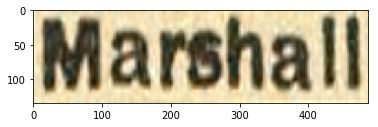

the matched words are (inorder): ['Marshal']
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


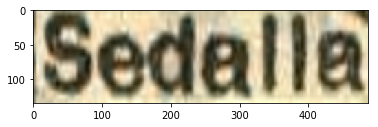

the matched words are (inorder): ['Sale']
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


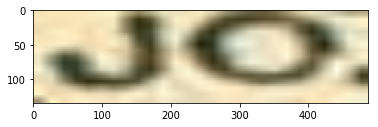

the matched words are (inorder): ['MEXIC']
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


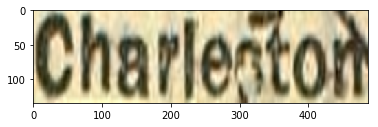

the matched words are (inorder): ['Connections']
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


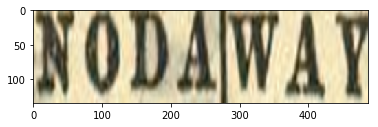

the matched words are (inorder): ['NODAWA']
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


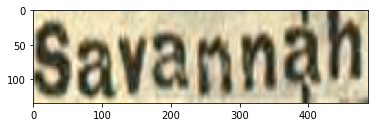

the matched words are (inorder): ['Savanna']
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


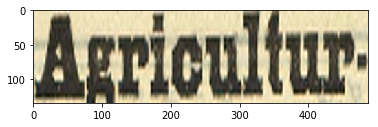

the matched words are (inorder): ['Litchfiel']
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


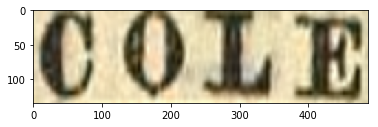

the matched words are (inorder): ['BOLL']
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


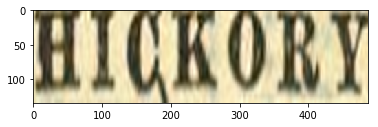

the matched words are (inorder): ['HICKOR']
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


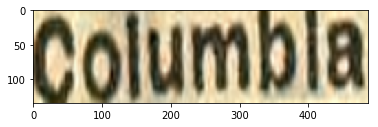

the matched words are (inorder): ['COL']
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


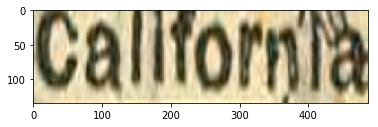

the matched words are (inorder): ['COOPE']
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


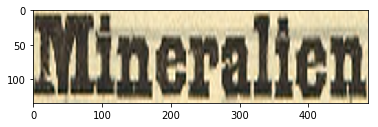

the matched words are (inorder): ['Mineralie']
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


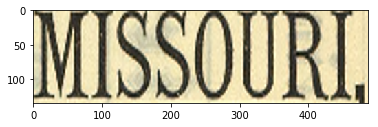

the matched words are (inorder): ['MISSOURI']
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


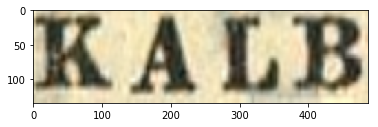

the matched words are (inorder): ['SALE']
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


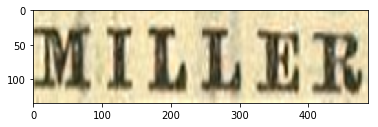

the matched words are (inorder): ['MILLE']
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


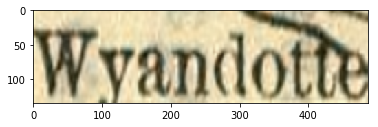

the matched words are (inorder): ['Wyandott']
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


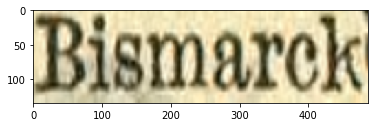

the matched words are (inorder): ['Barr']
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


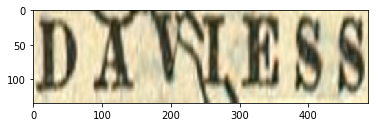

the matched words are (inorder): ['DAVIES']
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


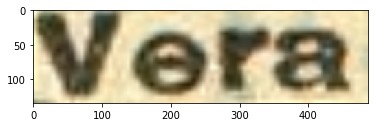

the matched words are (inorder): ['perr']
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


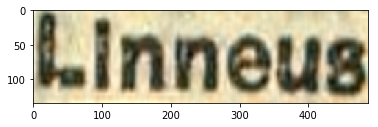

the matched words are (inorder): ['ne']
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


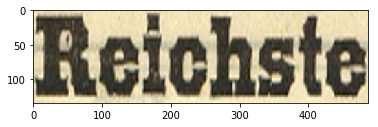

the matched words are (inorder): ['webste']
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


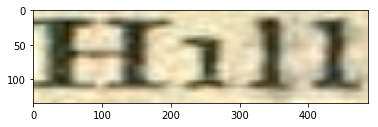

the matched words are (inorder): ['rall']
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


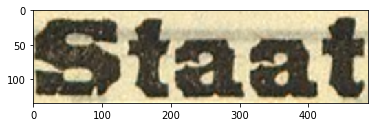

the matched words are (inorder): ['Sa']
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


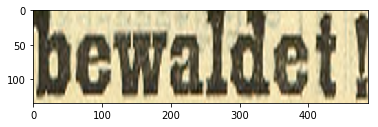

the matched words are (inorder): ['Bewaldet']
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


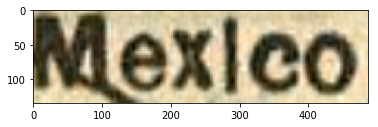

the matched words are (inorder): ['Mo']
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


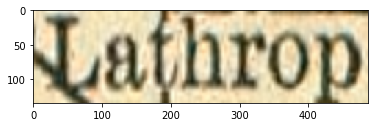

the matched words are (inorder): ['Carrol']
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


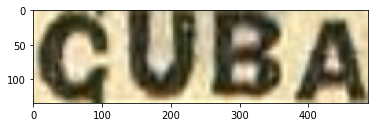

the matched words are (inorder): ['CEDA']
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


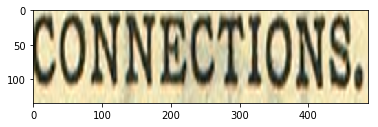

the matched words are (inorder): ['CONNECTIONS']
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


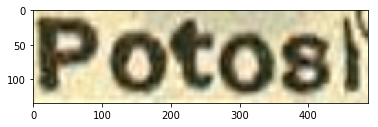

the matched words are (inorder): ['Potos']
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


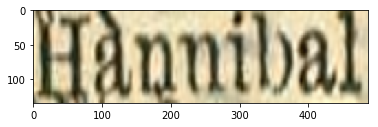

the matched words are (inorder): ['Hanniba']
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


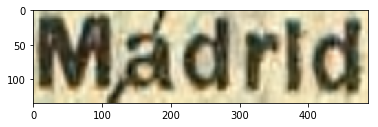

the matched words are (inorder): ['Madri']
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


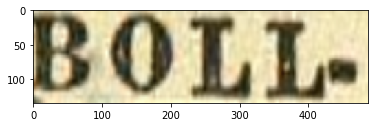

the matched words are (inorder): ['BOLL']
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


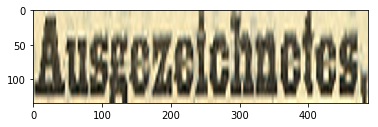

the matched words are (inorder): ['Associates']
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


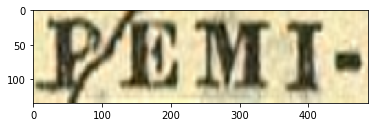

the matched words are (inorder): ['PETTI']
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


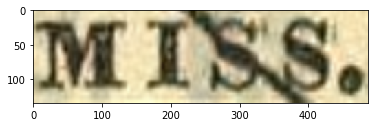

the matched words are (inorder): ['MISS']
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


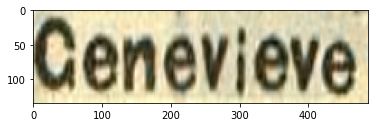

the matched words are (inorder): ['Cheste']
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


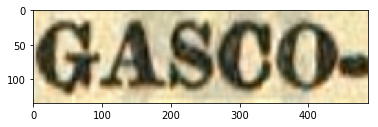

the matched words are (inorder): ['GASCO']
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


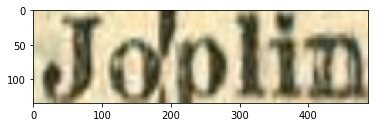

the matched words are (inorder): ['jopli']
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


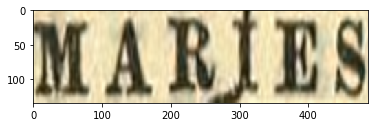

the matched words are (inorder): ['MARIE']
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


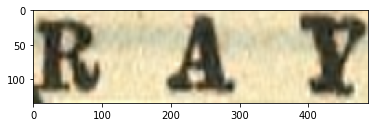

the matched words are (inorder): ['BARR']
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


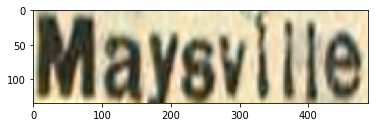

the matched words are (inorder): ['Maysvill']
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


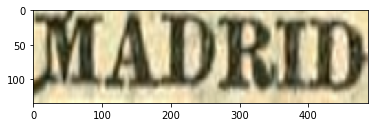

the matched words are (inorder): ['MARIO']
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


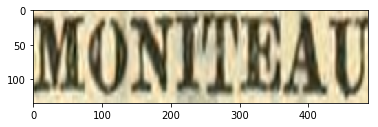

the matched words are (inorder): ['MONITEA']
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


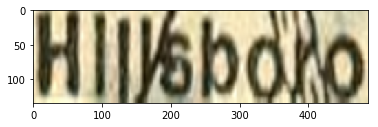

the matched words are (inorder): ['Washingto']
------------------------------------------------------------------------
------------------------------------------------------------------------


In [76]:
import matplotlib.pyplot as plt

count, matched_words, new_outputs, qualified_ids, img_dirs, new_word_strings = report_matches_with_variations(outputs, embedding_var,'cosine', word_strings,word_var_strings,1, 2)

print "the accuracy is: "+str(count/float(len(new_word_strings)))

_len = min(500, len(matched_words))
new_images = images[qualified_ids]
for i in range(_len):
    if img_dirs[i] != -1:
        continue
    print "************************************************************************"
    print "************************************************************************"
    print "Original image:"
    q = np.transpose(new_images[i],(1,2,0))
    plt.imshow(q)
    plt.show()
    print "the matched words are (inorder): "+str(matched_words[i])
    print "------------------------------------------------------------------------"
    print "------------------------------------------------------------------------"
pass

In [72]:
for i,d in enumerate(img_dirs):
    if d == 1:
        

32
49
52
68
82
102
120
122
136
138
174
186
191
193
199
205
222
230
237
241
249
260
261
274
275
289
298
300
303
320
323
337
351
359
363
364
370


63 Enoraver ['Enoraver']
66 IRON ['IRON']
80 Forsyth ['Fort']
106 Keytesville ['Keytesville']
138 RAILWAY, ['CALLAWAY']
161 Versailes ['Versailes']
167 AUDRAIN ['AUDRAIN']
203 Milan ['Milan']
273 Madrid ['Madrid']
285 Ausgezeichnetes, ['Associates,']
300 Eminence ['Bentonville']
309 Olathe ['Olathe']
329 Joplin ['Unionville']
367 MONITEAU ['MONITEAU']
the accuracy is: 0.792
************************************************************************
************************************************************************
Original image:


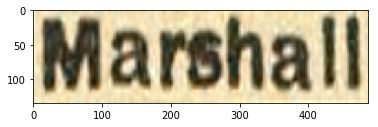

the matched words are (inorder): ['Marshall']
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


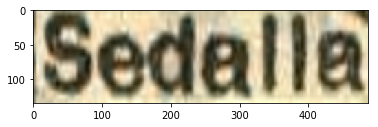

the matched words are (inorder): ['Sedalla']
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


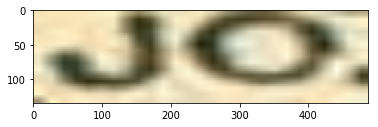

the matched words are (inorder): ['TEXAS']
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


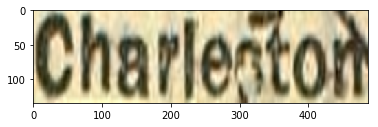

the matched words are (inorder): ['Centreville']
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


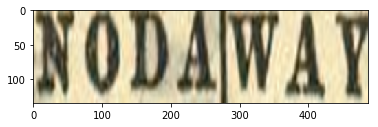

the matched words are (inorder): ['NODAWAY']
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


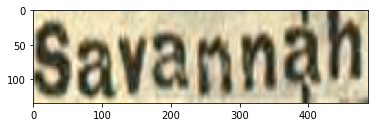

the matched words are (inorder): ['Savannah']
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


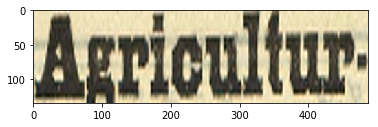

the matched words are (inorder): ['Associates,']
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


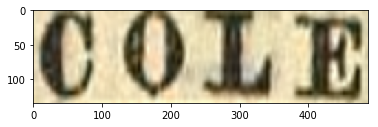

the matched words are (inorder): ['HOLT']
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


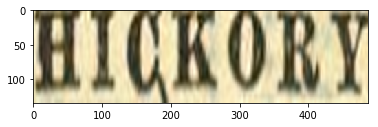

the matched words are (inorder): ['HICKORY']
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


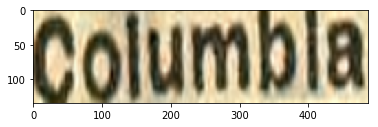

the matched words are (inorder): ['CARROLL']
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


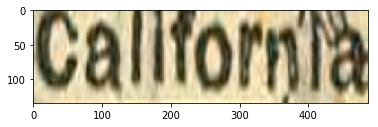

the matched words are (inorder): ['COOPER']
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


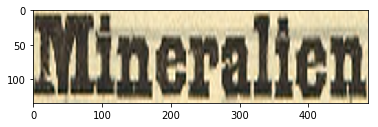

the matched words are (inorder): ['Mineralien']
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


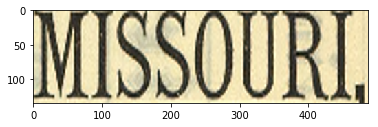

the matched words are (inorder): ['MISSOURI,']
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


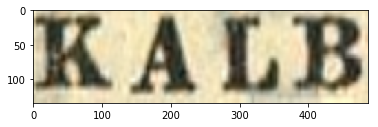

the matched words are (inorder): ['KALB']
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


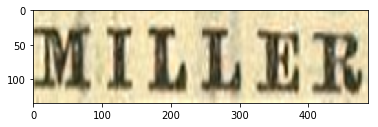

the matched words are (inorder): ['MILLER']
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


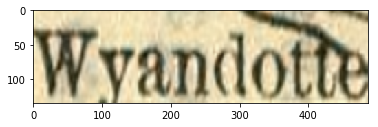

the matched words are (inorder): ['Wyandotte']
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


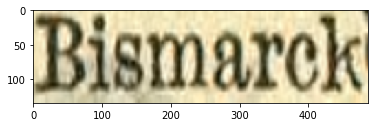

the matched words are (inorder): ['Bismarck']
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


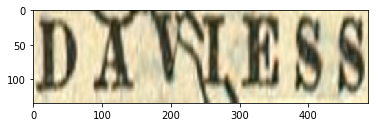

the matched words are (inorder): ['DAVIESS']
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


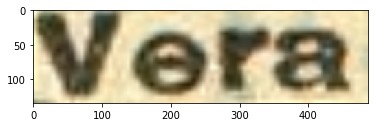

the matched words are (inorder): ['Vera']
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


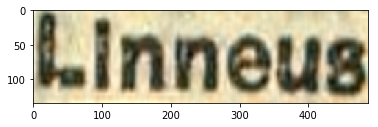

the matched words are (inorder): ['Linneus']
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


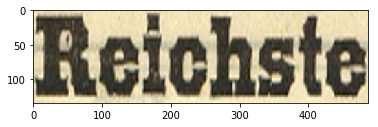

the matched words are (inorder): ['Reicheste']
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


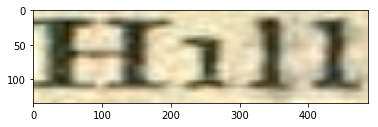

the matched words are (inorder): ['Hill']
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


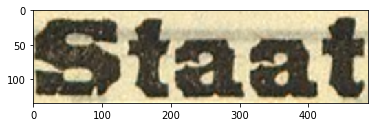

the matched words are (inorder): ['Staat']
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


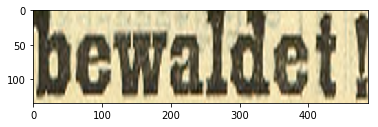

the matched words are (inorder): ['bewaldet!']
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


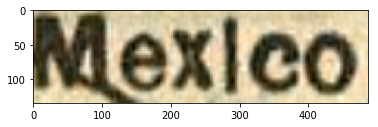

the matched words are (inorder): ['Mexico']
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


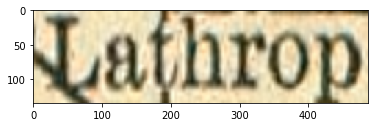

the matched words are (inorder): ['London']
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


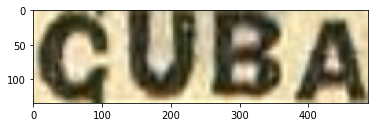

the matched words are (inorder): ['CUBA']
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


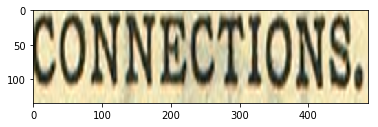

the matched words are (inorder): ['CONNECTIONS.']
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


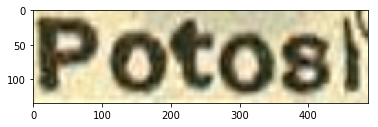

the matched words are (inorder): ['Potosi']
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


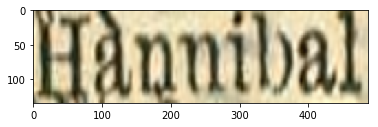

the matched words are (inorder): ['Hannibal']
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


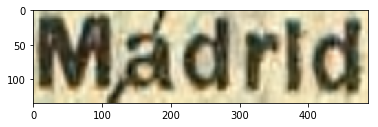

the matched words are (inorder): ['Madrid']
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


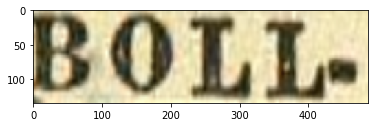

the matched words are (inorder): ['BOLL-']
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


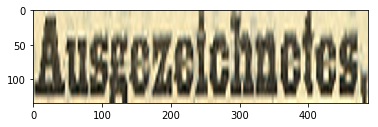

the matched words are (inorder): ['Associates,']
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


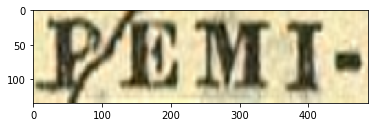

the matched words are (inorder): ['PLATTE']
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


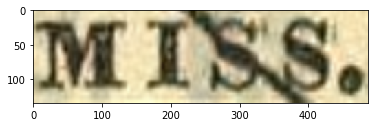

the matched words are (inorder): ['MADISON']
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


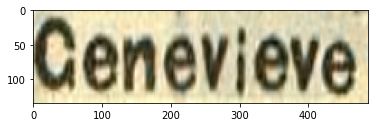

the matched words are (inorder): ['Centreville']
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


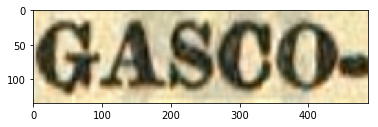

the matched words are (inorder): ['GASCO-']
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


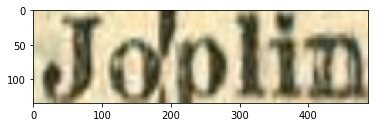

the matched words are (inorder): ['Unionville']
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


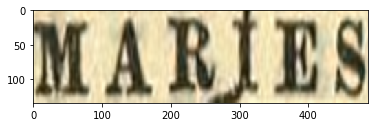

the matched words are (inorder): ['MARIES']
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


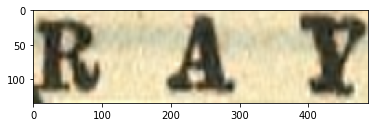

the matched words are (inorder): ['BARRY']
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


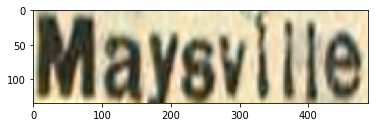

the matched words are (inorder): ['Maysville']
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


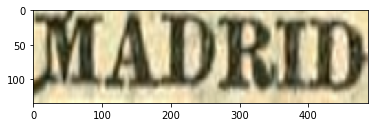

the matched words are (inorder): ['MADRID']
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


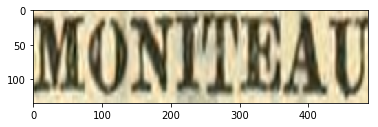

the matched words are (inorder): ['MONITEAU']
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************
Original image:


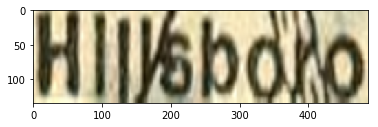

the matched words are (inorder): ['Hillsboro']
------------------------------------------------------------------------
------------------------------------------------------------------------


In [77]:
import matplotlib.pyplot as plt

count, matched_words, new_outputs, new_embedding, new_word_strings, \
    qualified_ids = report_matches(outputs, embedding, 'cosine', word_strings, 1, 2)

print "the accuracy is: "+str(count/float(len(new_word_strings)))

_len = min(500, len(matched_words))
new_images = images[qualified_ids]
for i in range(_len):
    if img_dirs[i] != -1:
        continue
    print "************************************************************************"
    print "************************************************************************"
    print "Original image:"
    q = np.transpose(new_images[i],(1,2,0))
    plt.imshow(q)
    plt.show()
    print "the matched words are (inorder): "+str(matched_words[i])
    print "------------------------------------------------------------------------"
    print "------------------------------------------------------------------------"
pass